<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final_modulos12_integra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminar - Downloads

In [ ]:
!pip install wandb
!wandb login

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
## Get dataset images

!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip "/content/train2017.zip"
!unzip "/content/val2017.zip"

In [ ]:
## Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!unzip "/content/stuff_annotations_trainval2017.zip"


# Preliminar - Preparação

In [ ]:
import wandb
wandb.init(project="image-to-label", entity="fabiormazza")

In [5]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [6]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms
import torchvision.models as models

from typing import Tuple
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn.modules.activation import Sigmoid

import transformers

In [ ]:
# Check which GPU we are using
!nvidia-smi

In [9]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# DATASETS - MÓDULOS 1 E 2

## DS - Módulo 1

In [ ]:
dataDir='/content'

## Annotations from instances of objects train/val

aFile_inst_train='{}/annotations/instances_train2017.json'.format(dataDir) ## Annotation file - train
aFile_inst_val='{}/annotations/instances_val2017.json'.format(dataDir) ## Annotation file - validation

## Annotations from "stuff" train/val

aFile_stuff_train='{}/annotations/stuff_train2017.json'.format(dataDir) ## Annotation file - train
aFile_stuff_val='{}/annotations/stuff_val2017.json'.format(dataDir) ## Annotation file - validation

coco_inst_train = COCO(aFile_inst_train)
coco_inst_val = COCO(aFile_inst_val)

coco_stuff_train = COCO(aFile_stuff_train)
coco_stuff_val = COCO(aFile_stuff_val)

In [ ]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.expand(3,-1,-1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class MyDataset1(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco_inst, coco_stuff, file_dir: str, transformations, num_cats: int):
    self.img_ids = img_ids
    self.coco_inst = coco_inst
    self.coco_stuff = coco_stuff
    self.transformations = transformations
    self.num_cats = num_cats

    ## Inputs
    #imgs_info = self.coco.loadImgs(self.img_ids)
    #imgs_url = [imgs_info[i]['coco_url'] for i in tqdm.notebook.tqdm(range(len(imgs_info)))]
    img_ids_str = list(map(str, img_ids))
    imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
    self.inputs = imgs

    ## Targets
    targets = torch.tensor([])

    for id in tqdm.notebook.tqdm(img_ids):
      ann_id_inst = self.coco_inst.getAnnIds(id)
      ann_id_stuff = self.coco_stuff.getAnnIds(id)

      anns_inst = self.coco_inst.loadAnns(ann_id_inst)
      anns_stuff = self.coco_stuff.loadAnns(ann_id_stuff)
      anns = anns_inst + anns_stuff      

      cat_idxs = [anns[j]['category_id'] for j in range(len(anns))]
      tgt = torch.zeros(self.num_cats)
      tgt[cat_idxs] = 1
      tgt = tgt.unsqueeze(0)
      targets = torch.cat((targets, tgt), dim=0)
    
    self.targets = targets


  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
all_cat_ids = coco_inst_train.getCatIds() + coco_stuff_train.getCatIds()
num_cats = all_cat_ids[-1] + 1 #zero is included to facilitate index identification, even if there is no cat with id = '0'

## DS - Módulo 1 - Verificação

In [ ]:
## Dataset

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset1(img_ids=dummy_image_ids, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_input, first_batch_target = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_input = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_input = torch.cat((correct_first_batch_input, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_input = correct_first_batch_input.view(5, 3, 224, 224)
correct_first_batch_input = torch.FloatTensor(correct_first_batch_input)

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert do input do dataset')

In [ ]:
## Verificação de um item do batch do dataset (input e target)
dummy_dataset[4]

In [ ]:
## Verificação visual do dataset (imagem e categorias = targets)
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
img, cats = dummy_dataset[4]
cats = torch.nonzero(cats).squeeze().numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst = cats[cats <= 91]
cats_stuff = cats[cats > 91]

print(coco_inst_train.loadCats(cats_inst), '\n', coco_stuff_train.loadCats(cats_stuff))

## DS Módulo 1 - Carregamento do Dataset

In [ ]:
##Número de exemplos do dataset
all_img_ids_train = coco_inst_train.getImgIds()
all_img_ids_val_test = coco_inst_val.getImgIds()

data_train_ex_num = len(all_img_ids_train)
data_valid_ex_num = int(len(all_img_ids_val_test) / 2) #validation coco dataset was divided in two sets, one being used as val and other as test (test set is not used in validation or training)
data_test_ex_num = int(len(all_img_ids_val_test) / 2)
all_ex_num = data_train_ex_num + data_valid_ex_num + data_test_ex_num

## Número de exemplos (truncado ou não)
train_ex_num = 50_000 #50_000
valid_ex_num = 2_500 #2_500
test_ex_num = 2_500 #2_500

max_lines = train_ex_num + valid_ex_num + test_ex_num

print(f"Number of examples used: {max_lines}; Number of examples in the dataset: {all_ex_num}")

## Carregamento do Dataset

img_ids_train = all_img_ids_train[:train_ex_num]
img_ids_val = all_img_ids_val_test[:valid_ex_num]
img_ids_test = all_img_ids_val_test[valid_ex_num:valid_ex_num + test_ex_num]

print(f"Train: {len(img_ids_train)}, Valid: {len(img_ids_val)}, Test: {len(img_ids_test)}")

valid_dataset1 = MyDataset1(img_ids=img_ids_val, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
test_dataset1 = MyDataset1(img_ids=img_ids_test, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
train_dataset1 = MyDataset1(img_ids=img_ids_train, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)

## DS - Módulo 2 - NLP Dataset

In [ ]:
from datasets import load_dataset
datasets2 = load_dataset('wikitext', 'wikitext-103-v1')

In [11]:
texts_train2 = [text for text in datasets2['train']['text'][:] if len(text) > 200]
texts_valid2 = [text for text in datasets2['validation']['text'][:] if len(text) > 200]
texts_test2 = [text for text in datasets2['test']['text'][:] if len(text) > 200]

In [ ]:
texts_train2[500]

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def tokenize(text: str, tokenizer=tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

In [ ]:
tokenize(texts_train2[500])[0:10]

In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenize(texts_train2[500])[0:10]))
print(tokenizer.convert_ids_to_tokens(tokenize(texts_train2[500])[-10:]))

In [16]:
class MyDataset2():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int):
        
        self.max_seq_length = max_seq_length
        cls = 101 
        tokens_all = torch.tensor([])
        inputs = torch.tensor([])
        targets = torch.tensor([])
 
        for text in tqdm.notebook.tqdm(texts):
            tokens = tokenize(text, tokenizer)
            tokens = [cls] + tokens
            tokens = torch.tensor(tokens, dtype=torch.int) ########### LongTensor
            tokens_all = torch.cat((tokens_all, tokens))
            #print(tokens_all)
        
        pad_size = max_seq_length - tokens_all.size(dim=0) % max_seq_length
        tokens_all = torch.cat((tokens_all, torch.zeros(pad_size)), dim=0) #pad_token_id = 0 (review if otherwise) / tokens_uns is the tokens tensor before reshaping
        inputs = tokens_all.reshape((-1, max_seq_length))

        t_tokens = torch.roll(tokens_all, -1, 0)
        t_tokens[-1] = 0
        targets = t_tokens.reshape((-1, max_seq_length))
        
        self.inputs = torch.tensor(inputs.numpy(), dtype=torch.int64) #######
        self.targets = torch.tensor(targets.numpy(), dtype=torch.int64) #######

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

## DS - Módulo 2 - Verificação

In [ ]:
## My Dataset Módulo 2

max_seq_length = 12

## Teste com frases longas

dummy_texts = ['The first Seattle Open was held 86 years ago in 1936 at Inglewood Golf Club in Kenmore in early August.\
 Macdonald Smith won an 18-hole playoff with a course record 65 (–8), six strokes ahead of runner-up Ralph Guldahl, \
 who won the next two U.S Opens (1937, 1938) and the Masters in 1939.', 
'Woods was responsible around 1790 for the design and building of Clissold House in Stoke Newington, for his uncle Jonathan Hoare.\
In 1806 he founded the London Architectural Society and became its first President.']

dummy_dataset = MyDataset2(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
dummy_loader = DataLoader(dummy_dataset, batch_size=20, shuffle=False)

first_batch_input, first_batch_target = next(iter(dummy_loader))

print(first_batch_input, first_batch_input.device)
print(first_batch_target, first_batch_input.device)

In [ ]:
pad_mask = first_batch_input == 0
#pad_mask.to(device)
pad_mask

In [ ]:
print(tokenize('I like to run.'))
print(tokenize('She likes to eat pizza.'))

In [ ]:
next(iter(dummy_loader))
dummy_input, _ = next(iter(dummy_loader))
print([tokenizer.convert_ids_to_tokens(token) for token in dummy_input])

## DS - Módulo 2 - Carregamento do dataset

In [ ]:
max_seq_length = 12

print(f'Texts train length:{len(texts_train2)} / Texts valid length:{len(texts_valid2)} / Texts test length:{len(texts_test2)}')

train_examples_num2 = 250_000 #50_000
valid_examples_num2 = 1500 #1_500
test_examples_num2 = 1500 #1_500

print(f'Truncating examples to: {train_examples_num2} / Texts valid length:{valid_examples_num2} / Texts test length:{test_examples_num2}')

train_texts2 = texts_train2[:train_examples_num2]
valid_texts2 = texts_valid2[:valid_examples_num2]
test_texts2 = texts_test2[:test_examples_num2]


valid_dataset2 = MyDataset2(texts=valid_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)
test_dataset2 = MyDataset2(texts=test_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)
train_dataset2 = MyDataset2(texts=train_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)

# Modelo 

# Modelo Módulo 2

In [18]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size: int, max_seq_length: int, embedding_dim: int, nhead: int, 
                 num_encoder_layers: int, num_decoder_layers: int, dim_feedforward: int, n_linear: int, dropout: float = 0.1, pad_token_id: int = 0):

        super(LanguageModel, self).__init__()

        self.num_embeddings = vocab_size
        self.max_seq_length = max_seq_length
        self.d_model = embedding_dim
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.n_linear = n_linear
        self.dropout = dropout
        self.pad_token_id = pad_token_id

        #Target causal mask
        causal_mask = torch.ones((self.max_seq_length, self.max_seq_length), dtype=torch.bool)
        causal_mask = torch.triu(causal_mask, diagonal=1)

        self.tgt_mask = causal_mask.to(device)

        self.embedding_decoder = torch.nn.Embedding(self.num_embeddings, self.d_model, device=device)
        self.positional_decoder = torch.nn.Parameter(torch.randn(self.max_seq_length, self.d_model, device=device)/10000)

        self.transformer = torch.nn.Transformer(d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, num_decoder_layers=self.num_decoder_layers, 
                               dim_feedforward=self.dim_feedforward, dropout=self.dropout, batch_first=True, device=device)
        
        self.linear = nn.Sequential(OrderedDict([
                              ('l1', torch.nn.Linear(self.d_model, self.n_linear, device=device)),
                              ('relu', torch.nn.ReLU()),
                              ('dropout', torch.nn.Dropout(p=0.20)),
                              ('l2', torch.nn.Linear(self.n_linear, self.num_embeddings, device=device, bias = False))
        ]))
    
    def forward(self, input_en, input_de):
        
        #Pad Masks
        decoder_pad_mask = input_de == self.pad_token_id
        decoder_pad_mask.to(device)
        
        #Decoder
        Y_de = self.embedding_decoder(input_de)
        Y_de = Y_de + self.positional_decoder

        #Encoder
        X_en = torch.zeros((input_en.shape[0], self.max_seq_length, self.d_model), device=device) ###### For now, change when encoder is used
        
        
        output_decoder = self.transformer(src=X_en, tgt=Y_de, tgt_mask=self.tgt_mask, tgt_key_padding_mask=decoder_pad_mask)
        
        output = self.linear(output_decoder)

        return output

# Teste modelo 2

In [ ]:
vocab_size = tokenizer.vocab_size
embedding_dim = 64
nhead = 2
num_encoder_layers = 0
num_decoder_layers = 2
dim_feedforward = 512
n_linear = 256

model_2 = LanguageModel(vocab_size, max_seq_length, embedding_dim, nhead, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, n_linear).to(device)

In [ ]:
sample_input, _ = next(iter(DataLoader(training_dataset2)))
sample_input = sample_input.to(device)
print(sample_input.shape, sample_input.device)
sample_output = model_2(sample_input, sample_input)
print(f'sample_input.shape: {sample_input.shape}, device={sample_input.device}, type={sample_input.dtype}')
print(f'sample_output.shape: {sample_output.shape}, device={sample_input.device}, type={sample_output.dtype}')
num_params = sum(p.numel() for p in model_2.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

## Assert da Perplexidade

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target, ignore_token_id: int):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, seq_length, vocab_size)
        target: a LongTensor of shape (batch_size, seq_length)

    Returns:
        A float corresponding to the perplexity
    """
    logits = logits.reshape(-1, logits.shape[-1]) #.detach().to('cpu')
    #logits = torch.FloatTensor(logits)
    target = target.reshape(-1) #.detach().to('cpu')
    #target = target.long()
    loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=ignore_token_id)
    
    return torch.exp(loss)


n_examples = 1000

train_input_ids, train_target_ids = next(iter(DataLoader(training_dataset2, batch_size=n_examples)))
train_input_ids = train_input_ids.to(device)
train_target_ids = train_target_ids.to(device)

logits = model_2(train_input_ids, train_input_ids)

my_perplexity = perplexity(logits=logits, target=train_target_ids, ignore_token_id=tokenizer.pad_token_id)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=7000)
print('Passou o no assert da perplexidade')

# Modelo módulo 1

In [ ]:
class MultiLabelClassifier(nn.Module):

    def __init__(self, num_cats):
        super().__init__()
        self.num_cats = num_cats
        self.backbone = models.resnet34(pretrained=True)
        self.model_1_wo_fc = nn.Sequential(*(list(self.backbone.children())[:-1])).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=512, out_features=256),
            nn.Dropout(p=0.20),
            nn.Linear(in_features=256, out_features=num_cats),
            ##nn.Sigmoid() - included in BCEWithLogitsLoss
        ).to(device)
    
    def forward(self, input):
        y_hat = self.model_1_wo_fc(input)
        y_hat = torch.flatten(y_hat, 1)
        y_hat = self.classifier(y_hat)

        return y_hat

#Teste do Modelo - Módulo 1

In [ ]:
#model_1_test = MultiLabelClassifier(num_cats=num_cats)

#sample_input, _ = next(iter(DataLoader(train_dataset)))
#sample_output = model_1_test(sample_input.to(device))

#print(f'sample_input.shape: {sample_input.shape}')
#print(f'sample_output.shape: {sample_output.shape}')

#num_params = sum(p.numel() for p in model_1_test.parameters() if p.requires_grad)
#print(f'Number of model parameters: {num_params}')

#Laço de treinamento

In [ ]:
max_examples = 10_000_000
eval_every_steps = 1000
lr = 6e-4

vocab_size = tokenizer.vocab_size
embedding_dim = 256
nhead = 4
num_encoder_layers = 0
num_decoder_layers = 4
dim_feedforward = 1024
n_linear = 1024

model_2 = LanguageModel(vocab_size, max_seq_length, embedding_dim, nhead, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, n_linear).to(device)

train_loader2 = DataLoader(train_dataset2, batch_size=128, shuffle=True, drop_last=True)
validation_loader2 = DataLoader(valid_dataset2, batch_size=128)

optimizer2 = torch.optim.Adam(model_2.parameters(), lr=lr)

def train_step(input_ids, target_ids):
    model_2.train()
    model_2.zero_grad()
    logits = model_2(input_ids, input_ids)
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model_2.pad_token_id)
    loss.backward()
    optimizer2.step()

    return loss.item()


def validation_step(input_ids, target_ids):
    model_2.eval()
    logits = model_2(input_ids, input_ids)
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model_2.pad_token_id)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input_ids, train_target_ids in train_loader2:
        loss = train_step(train_input_ids.to(device), train_target_ids.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(val_input_ids.to(device), val_target_ids.to(device))
                    for val_input_ids, val_target_ids in validation_loader2]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        wandb.log({'train ppl:': train_ppl, 'valid ppl:': valid_ppl})

        n_examples += len(train_input_ids)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

In [ ]:
prompt = 'The first Seattle Open was held 86 years ago in 1936 at'# Inglewood Golf Club in Kenmore in early August. Macdonald Smith won'
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(torch.LongTensor([input_ids_truncated]).to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

In [ ]:
max_examples = 250_000
eval_every_steps = 100
lr = 1e-4

model_1 = MultiLabelClassifier(num_cats=num_cats)

train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True, drop_last=True)
validation_loader1 = DataLoader(valid_dataset1, batch_size=64)

optimizer1 = torch.optim.Adam(model_1.parameters(), lr=lr)

def train_step(inputs, targets):
    model_1.train()
    model_1.zero_grad()
    outputs1 = model_1(inputs)
    #outputs = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion1 = nn.BCEWithLogitsLoss()
    loss1 = criterion1(outputs1, targets1)

    optimizer1.step()

    #loss.backward()
    return loss.item()


def validation_step(inputs, targets):
    model_1.eval()
    outputs = model_1(inputs)
    #logits = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(outputs, targets)
    return loss.item()

def f1_score(inputs, targets, threshold=0.35):
    model_1.eval()
    sigmoid = torch.nn.Sigmoid()
    outputs = sigmoid(model_1(inputs))
    outputs[outputs >= threshold] = 1.0
    outputs[outputs < threshold] = 0.0
    
    n_true_positives = (outputs.bool() & targets.bool()).sum().item()
    n_false_positives = ((outputs.bool() ^ targets.bool()) & outputs.bool()).sum().item()
    n_false_negatives = ((outputs.bool() ^ targets.bool()) & targets.bool()).sum().item()

    precision = n_true_positives / (n_true_positives + n_false_positives)
    recall = n_true_positives / (n_true_positives + n_false_negatives)
    f1_score = (2 * precision * recall) / (precision + recall)

    return f1_score

train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input, train_target in train_loader:
        loss = train_step(train_input.to(device), train_target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)

            with torch.no_grad():
                valid_loss = np.average([
                    validation_step(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])
                
                valid_f1_score = np.average([
                    f1_score(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])
                
                wandb.log({'train loss:': train_loss, 'valid loss': valid_loss, 'valid_f1_score': valid_f1_score})

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, valid loss: {valid_loss:.6f}, valid f1_score: {valid_f1_score:.6f}')
            train_losses = []

        n_examples += len(train_input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

#Avaliação do módulo 1 (model_1) no dataset de teste

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_loss = np.average([
        validation_step(test_input.to(device), test_target.to(device))
        for test_input, test_target in test_loader
    ])

    test_f1_score = np.average([
       f1_score(test_input.to(device), test_target.to(device))
       for test_input, test_target in test_loader])

print(f'test loss: {test_loss}; test f1_score: {test_f1_score}')

test loss: 0.09488611537963151; test f1_score: 0.6166502222089747


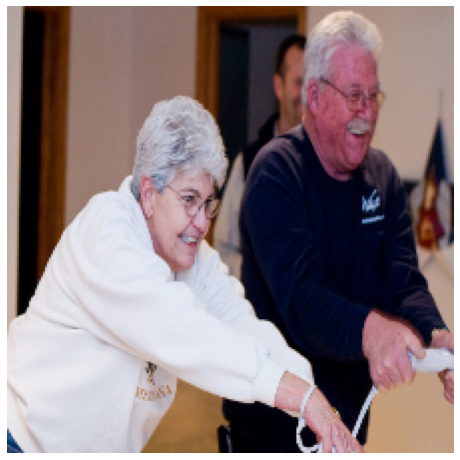

Categorias - TARGET
person ,  remote ,  cell phone ,  carpet ,  clothes ,  wall-concrete ,  wall-wood ,  other ,  
 Categorias - Classificação do modelo
person ,  clothes ,  wall-concrete ,  other ,  

In [ ]:
## Teste com exemplo de teste

inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])

index = random.randrange(test_ex_num)
img, cats = test_dataset[index]

## Image categories (random image from the test set)
cats = torch.nonzero(cats).squeeze(1).numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst_ids = cats[cats <= 91]
cats_inst = coco_inst_val.loadCats(cats_inst_ids)
cats_stuff_ids = cats[cats > 91]
cats_stuff = coco_stuff_val.loadCats(cats_stuff_ids)

print('Categorias - TARGET')
for i in range(len(cats_inst)):
    print(cats_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_stuff)):
    print(cats_stuff[i]['name'], ', ', end=' ')

## Image predicted categories
model_1.eval()
img = img.to(device)
img = img.unsqueeze(0)
cats_predicted = model_1(img)
threshold = 0.35
cats_predicted[cats_predicted >= threshold] = 1
cats_predicted[cats_predicted < threshold] = 0
cats_predicted = cats_predicted.squeeze()
cats_predicted = torch.nonzero(cats_predicted).squeeze(1).cpu().numpy()

cats_predicted_inst_ids = cats_predicted[cats_predicted <= 91]
cats_predicted_inst = coco_inst_val.loadCats(cats_predicted_inst_ids)
cats_predicted_stuff_ids = cats_predicted[cats_predicted > 91]
cats_predicted_stuff = coco_stuff_val.loadCats(cats_predicted_stuff_ids)

print('\n Categorias - Classificação do modelo')
for i in range(len(cats_predicted_inst)):
    print(cats_predicted_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_predicted_stuff)):
    print(cats_predicted_stuff[i]['name'], ', ', end=' ')
